In [1]:
import nltk
from nltk.corpus import stopwords
import csv
from scipy.spatial import distance
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

# Q1 function
def tokenize(text):
    
    tokens = None
    text_lower = text.lower()
    stop_words = set(stopwords.words('english'))
    pattern = r'[a-zA-Z]+[-\._\']*[a-zA-Z]+'
    token1 = nltk.regexp_tokenize(text_lower,pattern)
    tokens = [i for i in token1 if i not in stop_words]
    return tokens


# Q3 function

def find_similar_doc(docs,  doc_id):
    top_sim_index, top_sim_score = None, None
    # Use the Q1 function to tokenize each doc in docs
    tokens = [tokenize(i) for i in docs]
    dic = [nltk.FreqDist(token) for token in tokens]
    docs_tokens={idx:doc for idx,doc in enumerate(dic)}
    
    # Get document-term matrix
    dtm = pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm = dtm.fillna(0)
    dtm = dtm.sort_index(axis = 0) 
    
    # Get normalized term frequency (tf) matrix
    tf = dtm.values
    doc_len = tf.sum(axis = 1)
    tf = np.divide(tf, doc_len[:,None])
    
    # Get idf
    df = np.where(tf > 0,1,0)
    idf = np.log(np.divide(len(docs), np.sum(df, axis = 0))) + 1
    smoothed_idf = np.log(np.divide(len(docs) + 1, np.sum(df, axis = 0) + 1)) + 1
    
    # Get tf-idf
    tf_idf = normalize(tf * idf)
    smoothed_tf_idf = normalize(tf * smoothed_idf)

    # Use the smoothed_tf_idf to compare the distence between target and others
    target = smoothed_tf_idf[doc_id,:] 
    score = [1 - distance.cosine(target, smoothed_tf_idf[i,:]) for i in range(len(docs))]
    dtm['score'] = score 
    dtm_sort = dtm.sort_values(by=['score'],ascending=False)
    top_sim_index = dtm_sort.index.values[1]
    top_sim_score = dtm_sort['score'].values[1]
    
    
    return top_sim_index, top_sim_score

In [2]:
# Lab
data = pd.read_csv("amazon_review_300.csv")
docs = data["review"]
# Use the Q1 function to tokenize each doc in docs
tokens = [tokenize(i) for i in docs]
dic = [nltk.FreqDist(token) for token in tokens]
docs_tokens={idx:doc for idx,doc in enumerate(dic)}
# Get document-term matrix
dtm = pd.DataFrame.from_dict(docs_tokens, orient="index" )
dtm = dtm.fillna(0)
dtm = dtm.sort_index(axis = 0) 


In [3]:
result_arr = np.array([find_similar_doc(docs,i) for i in range(300)])
col1 = result_arr[:,0]
col2 = result_arr[:,1]
dtm['top_sim_index'] = col1
dtm['top_sim_score'] = col2
result = dtm.iloc[:,[-2,-1]]


In [7]:
result.describe()

,top_sim_index,top_sim_score
count,300.000000,300.000000
mean,153.280000,0.191250
std,91.399752,0.104174
min,1.000000,0.055308
25%,69.000000,0.125883
50%,156.000000,0.166524
75%,232.500000,0.223430
max,299.000000,0.911463


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1168b6cc0>]],
      dtype=object)

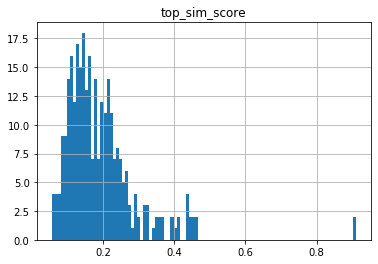

In [12]:
result.hist('top_sim_score',bins = 100)

In [20]:
sort = result.sort_values(by=['top_sim_score'],ascending = False)

In [27]:
sort.tail(15)

,top_sim_index,top_sim_score
65,70.0,0.082320
262,109.0,0.081186
167,44.0,0.081137
16,21.0,0.079655
179,292.0,0.076637
38,211.0,0.073108
136,176.0,0.072661
260,186.0,0.071986
60,1.0,0.071899
22,188.0,0.067669


# Testing

In [6]:

# pick any doc id, e.g. 10, 207
doc_id =207
sim_doc_id, sim = find_similar_doc(data["review"], doc_id)
print("\nSimilarity between {0} and {1} is {2:.2f}: "\
          .format(doc_id, sim_doc_id, sim))
print("\nselected doc: ", data.loc[doc_id]["review"])
print("\nsimilar doc: ", data.loc[sim_doc_id]["review"])
    
    
doc_id =10
sim_doc_id, sim = find_similar_doc(data["review"], doc_id)
print("\nSimilarity between {0} and {1} is {2:.2f}: "\
          .format(doc_id, sim_doc_id, sim))
print("\nselected doc: ", data.loc[doc_id]["review"])
print("\nsimilar doc: ", data.loc[sim_doc_id]["review"])
    


Similarity between 207 and 206 is 0.20: 

selected doc:  I have been using this product for 5+ years. It was wonderful. About 1 year ago the company changed packaging and the product changed slightly. The bottle is taller now and something is missing from the serum. Doesn't work as well as it used to work. I will not be purchasing this item because of the change.

similar doc:  I have been used this product for many years. But somehow the product I received this time is like fake one. It's very thin. I have to used double amount.

Similarity between 10 and 15 is 0.16: 

selected doc:  A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book.

similar doc:  It's glaringly obvious that all of the glowing reviews have been written by the same person, perhaps the author herself. They all have the same misspellings and poor sentence structure th

In [25]:
def test(doc_id):
    sim_doc_id, sim = find_similar_doc(data["review"], doc_id)
    print('\n')
    print("\nSimilarity between {0} and {1} is {2:.2f}: "\
          .format(doc_id, sim_doc_id, sim))
    print("\nselected doc: ", data.loc[doc_id]["review"])
    print("\nsimilar doc: ", data.loc[sim_doc_id]["review"])
    